**ВЕДЕНИЕ**

**1.** Рассмотрим в общих чертах данные нам данные об играх 

**2.** Проведем предобработку данных: заполним пропуски, где это возможно, уберем явные дубликаты и по, возможности нахождения, неявные, добавим необходимые для будущего анализа столбцы

**3.** Исследовательский анализ: опеределим акутальный период, время жизни платформы, найдем самые прибыльные платформы и жанры, а также корелляцию продаж от оценок пользователей и критиков.

**4.** Составим портрет пользователя регионов **NA**, **EU** и **JP**

**5.** Проверка гипотез

**6.** Вывод


## Общая информация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
from scipy import stats as st
sns.set_theme(style="darkgrid")

In [2]:
try:
    data = pd.read_csv('C:/Users/rusla/Downloads/games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

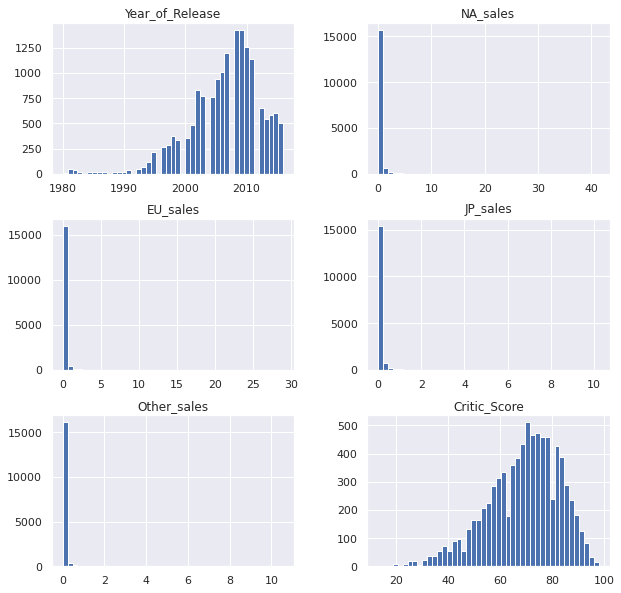

In [5]:
data.hist(bins=45,figsize=(10,10))
plt.show()

## Предобработка

In [6]:
data.rename(str.lower, axis='columns', inplace = True)
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Комментарий: Cтолбец **Year_of_Release** должен быть **int**, так как год - целое число.

In [7]:
data['year_of_release'] = data['year_of_release'].astype('Int64')
data.dtypes

name                object
platform            object
year_of_release      Int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

Комментарий: Значения в столбце **user_score** tbd означает to be determined или будет опеределено. Оценка по каким то причинам еще не выялвена среди пользователей, значит такое значение можно спокойно причислить к NaN поскольку достовернного значения вытащить из этой информации не получиться. К тому же преобразуем тип во **float**

In [8]:
print('Количество пропусков user_score до преобразования:',data['user_score'].isna().sum())
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
print('Количество пропусков user_score после преобразования:',data['user_score'].isna().sum())

Количество пропусков user_score до преобразования: 6701
Количество пропусков user_score после преобразования: 9125


In [9]:
data.query('name.isnull()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Комментарий: Всего 2 пропуска в стобце **name**, и там же пропущены **genre** и почти все другие значения, небольшая потеря.

In [10]:
print('Количество данных до удаления:',len(data))
data.drop(data[data['name'].isna()].index, inplace=True)
print('Количество данных после удаления:',len(data))

Количество данных до удаления: 16715
Количество данных после удаления: 16713


Комментарий: Поскольку год будет играть важную роль в нашем анализе, удалим пропуски связанные с ним, их не так много. 

In [11]:
print('Количество данных до удаления:',len(data))
data.drop(data[data['year_of_release'].isna()].index, inplace=True)
print('Количество данных после удаления:',len(data))

Количество данных до удаления: 16713
Количество данных после удаления: 16444


In [12]:
print('Количество уникальных имен игр:',len(data['name'].unique()))

Количество уникальных имен игр: 11426


Комментарий: Были обнаружены следующие неявные дубликаты, встает вопрос, стоит ли объединять продажи, все совпадает кроме них. Тут без пояснение того, как данные собирались не обойтись, но так как в дубликате очень мало, можно объединить, сильно на выборку не повлияет. 

In [13]:
data[data.loc[:,['name','platform']].duplicated(keep='first')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.0,0.13,0.02,0.10,83.0,8.5,T
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.0,0.06,0.00,0.02,82.0,8.5,T
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.00,0.00,83.0,5.5,E


In [14]:
data[data.loc[:,['name','platform']].duplicated(keep='last')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T


In [15]:
duplicate_list = data[data.loc[:,['name','platform']].duplicated(keep='first')].sort_values(by=['name']).index
origin_list = data[data.loc[:,['name','platform']].duplicated(keep='last')].sort_values(by=['name']).index
for index in range(0,len(origin_list)):
    data.loc[origin_list[index], ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']] += \
    data.loc[duplicate_list[index], ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']]

In [16]:
print('Количество данных до удаления:',len(data))
data.drop(data[data.loc[:,['name','platform']].duplicated(keep='first')].index, inplace=True)
print('Количество данных после удаления:',len(data))

Количество данных до удаления: 16444
Количество данных после удаления: 16441


Комментарий: Посмотрим сколько пропусков осталось

In [17]:
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
dtype: int64

Комментарий: Все NaN поменяем на Unknown, значения составляющие пренебрежительно малую часть - удалим. 

In [18]:
data['rating'].fillna('Unknown', inplace=True)

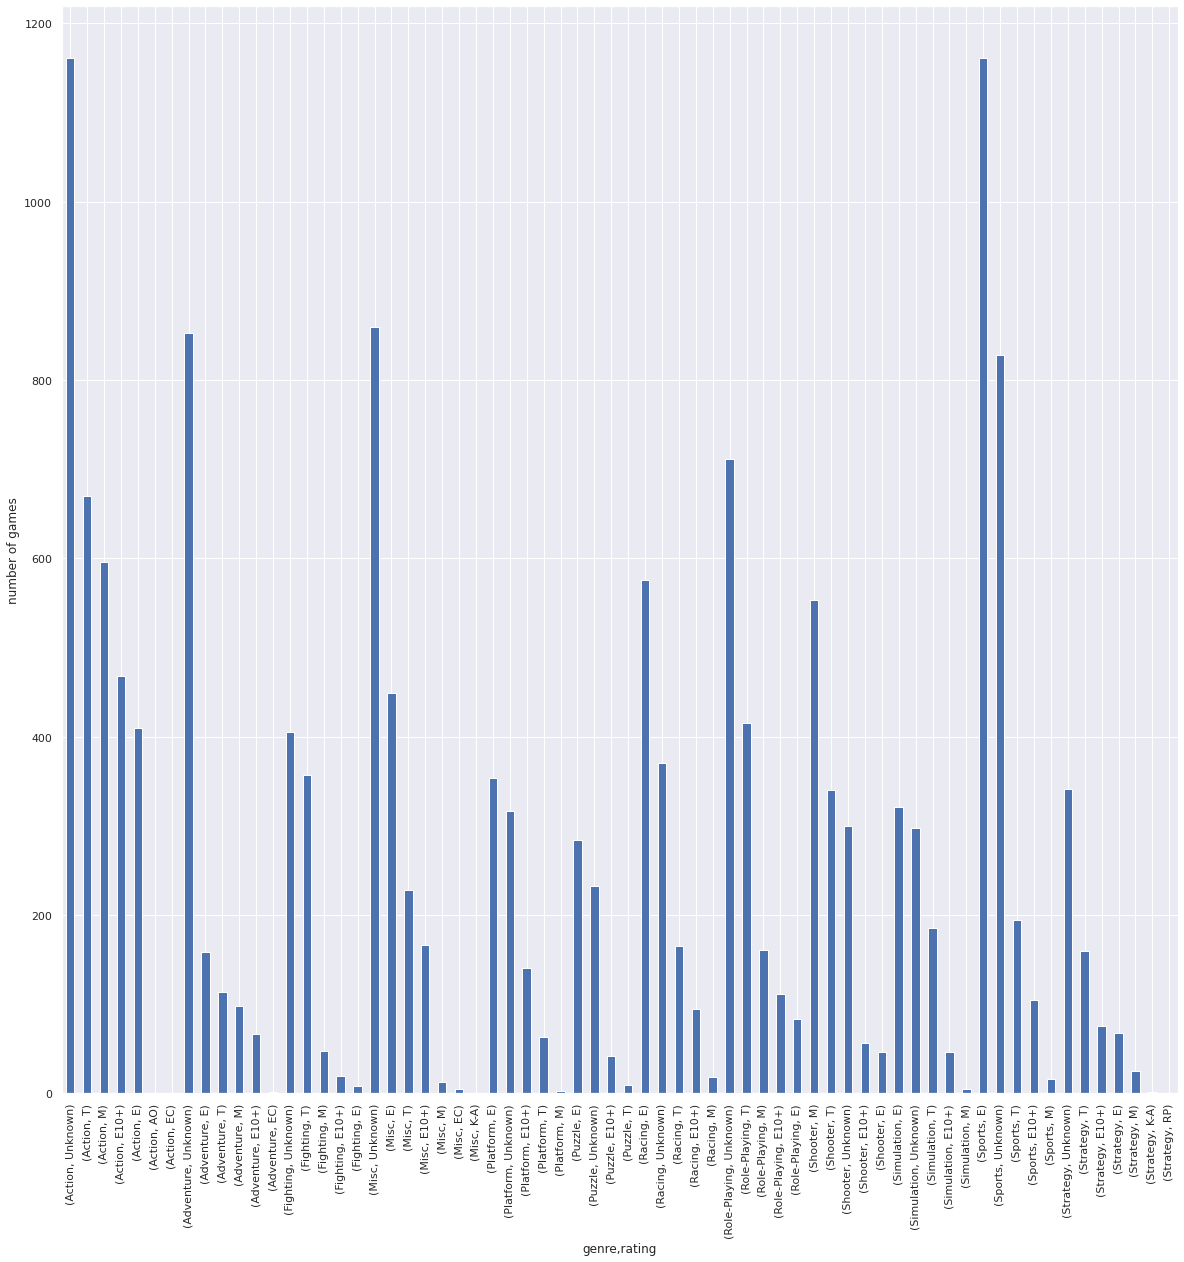

In [19]:
data.groupby('genre')['rating'].value_counts().plot(kind='bar', figsize = (20,20), grid=True)
plt.ylabel('number of games')
plt.show()

In [20]:
rating_to_delete = data['rating'].value_counts()[-4:].index
print('Количество данных до удаления:',len(data))
data.drop(data.query('rating in @rating_to_delete').index, inplace=True)
print('Количество данных после удаления:',len(data))

Количество данных до удаления: 16441
Количество данных после удаления: 16428


In [21]:
data.reset_index(drop=True, inplace=True)

In [22]:
data['total_sales'] = data.loc[:,'na_sales':'other_sales'].sum(axis=1)

In [23]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Unknown,31.38


## Исследовательский анализ

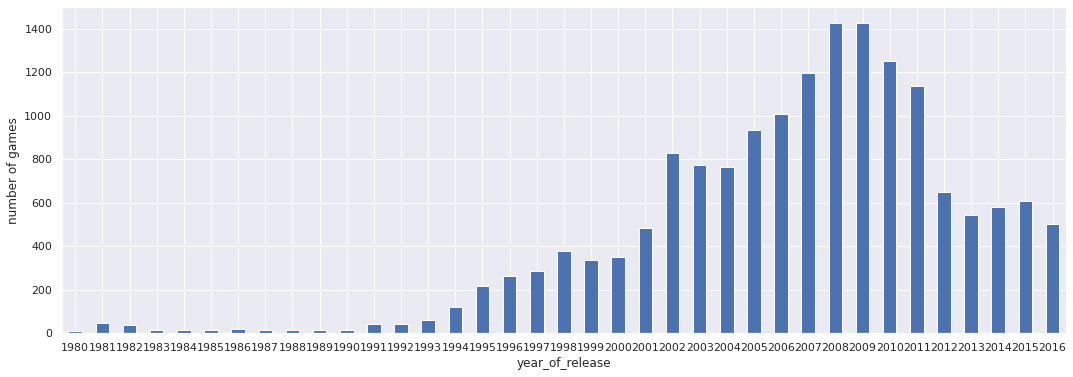

In [24]:
data.groupby('year_of_release')['name'].agg('count').plot(kind='bar', figsize=(18,6), rot=0, grid = True)
plt.ylabel('number of games')
plt.show()

Комментарий: Данные за все периоды не важны, поскольку рынок меняется, технологии меняются и т.д. С 2009 года количество выходящий игр стало уменьшаться, рынок изменился, как минимум поэтому данные до этого промежутка нам точно интересны, в 2012 произошел скачок, количество выходящих игр уменьшилось почти на половину, по сравнению с 2011 годом. Последние 3 года самый оптимальный выбор для актуального периода.

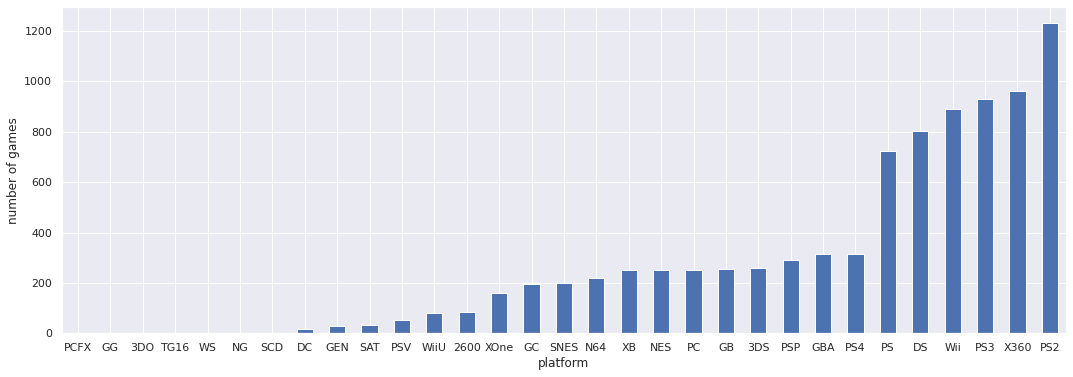

In [25]:
data.groupby('platform')['total_sales'].sum().sort_values().plot(kind='bar', figsize=(18,6), rot=0, grid=True)
plt.ylabel('number of games')
plt.show()

<AxesSubplot:xlabel='platform', ylabel='year_of_release'>

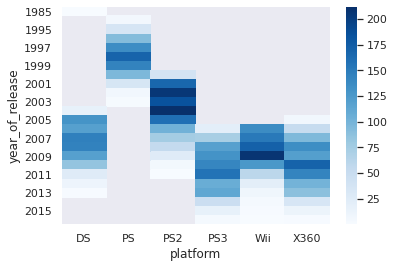

In [26]:
biggest_platform = data.groupby('platform')['total_sales'].sum().sort_values().index[-6:]
data_biggest_platform = data.query('platform in @biggest_platform')
pivot_platform = data_biggest_platform.pivot_table(index='year_of_release', 
                                                   columns='platform', values='total_sales', aggfunc='sum')
sns.heatmap(pivot_platform, cmap='Blues')


In [27]:
print('Cредняя продолжительности жизни платформы:', end=' ')
print((data.groupby('platform')['year_of_release'].max() - data.groupby('platform')['year_of_release'].min()).mean())

Cредняя продолжительности жизни платформы: 7.612903225806452


In [28]:
data_actual = data.query('year_of_release >= 2014')

Комментарий: Выберем потенциально прибыльные платформы

<AxesSubplot:xlabel='platform', ylabel='year_of_release'>

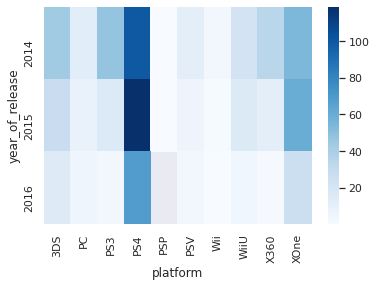

In [29]:
sns.heatmap(data_actual.pivot_table(index='year_of_release', columns='platform', 
                                    values='total_sales', aggfunc='sum'), cmap='Blues')

Комментарий: Как видно на графкие, на пике находятся **PS4** и **Xone**, они вытеснили **PS3** и **X360**. Можно в качестве 3 платформы взять **3DS**, не считая гигантов, у нее лучше показатели среди остальных.

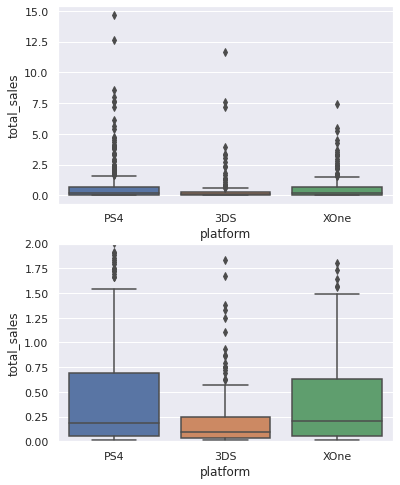

In [30]:
most_sales_platform = ['PS4', 'XOne', '3DS']
fig_1, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
sns.boxplot(ax = ax1,x='platform', y='total_sales',data=data_actual.query('platform in @most_sales_platform'))
sns.boxplot(ax = ax2, x='platform', y='total_sales',data=data_actual.query('platform in @most_sales_platform'))
ax2.set_ylim(0,2)
plt.show()

Комментарий: Мы имеем довольно неплохое количество выбросов продаж, причем по всем платформам, скорее всего это просто очень продаваемые игры, гораздо лучше медианного значения, это вполне возможно. Первый квантиль очень близко к нулю, что дополнительно говорит нам что большая часть продаж гораздо меньше.

Комментарий: Самая популярная платформа это PS4, на ее данных рассмотрим связь 

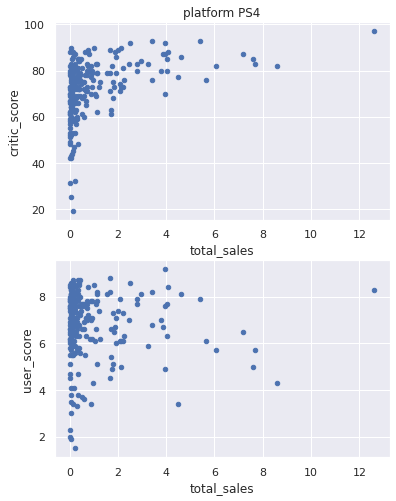

In [31]:
fig_2, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
data_actual[data_actual['platform'] == 'PS4'].plot(ax = ax1, x='total_sales', y='critic_score', kind='scatter', grid=True)
data_actual[data_actual['platform'] == 'PS4'].plot(ax = ax2, x='total_sales', y='user_score', kind='scatter', grid=True)
ax1.set_title('platform PS4')
plt.show()

Комментарий: Таким образом оценки пользователей не оказывают влиятния на продажи, а вот критиков оказывают, но не сильно. К тому же, диаграммы рассеивания показывают как раз выбросы продаж, какие были на графиках **boxplot**.

In [32]:
data_actual.groupby('platform')[['critic_score','user_score']].count().sort_values(['critic_score'], ascending=False)

,critic_score,user_score
platform,,
PS4,237,242
XOne,155,165
PC,116,122
PSV,54,73
3DS,51,55
WiiU,43,48
PS3,36,98
X360,26,83
PSP,0,0


In [33]:
corr_data = pd.DataFrame()
for platform in data_actual.groupby('platform')[['critic_score','user_score']].count().sort_values(['critic_score'], ascending=False).index[:8]:
    temp_row = {'platform':platform, 
                'critic_score_corr':data_actual.loc[data_actual['platform'] == platform, 'critic_score']
                .corr(data_actual.loc[data_actual['platform'] == platform, 'total_sales']),
                'user_score_corr':data_actual.loc[data_actual['platform'] == platform, 'user_score']
                .corr(data_actual.loc[data_actual['platform'] == platform, 'total_sales'])}
    corr_data = corr_data.append(temp_row, ignore_index = True)

In [34]:
corr_data

,critic_score_corr,platform,user_score_corr
0,0.402661,PS4,-0.040132
1,0.428677,XOne,-0.070384
2,0.174634,PC,-0.071597
3,0.042665,PSV,-0.168455
4,0.314117,3DS,0.215193
5,0.370201,WiiU,0.407926
6,0.446575,PS3,-0.166761
7,0.525723,X360,-0.138445


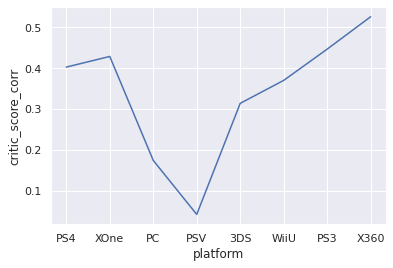

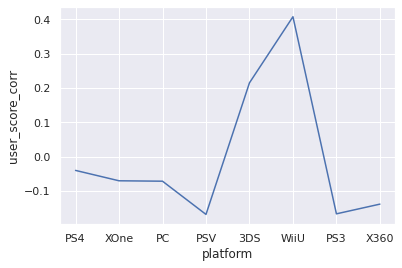

In [35]:
sns.lineplot(data=corr_data, x='platform', y = 'critic_score_corr')
plt.show()

sns.lineplot(data=corr_data, x='platform', y = 'user_score_corr')
plt.show()

Комментарий: На данных графиках мы можем увидеть как меняется корреляция продаж от оценок критиков и пользователей в зависимости от платформы. Аномальными относительно остальных я считаю стоит выделить для **critic_score** платформы **PC**, **PSV** и **3DS**. Для **user_score** платформы **3DS** и **WiiU**. С помощью данных графиков можно понять как пользователи доверяют оценкам на различных платформы.

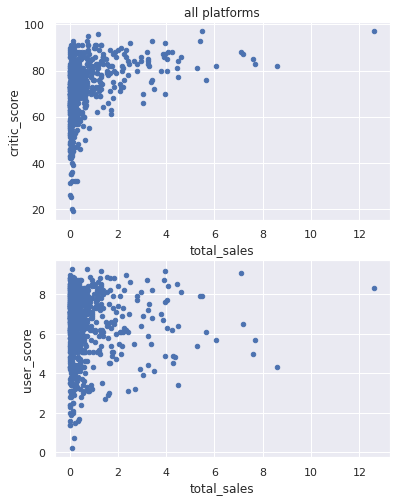

In [36]:
fig_3, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
data_actual.plot(ax = ax1, x='total_sales', y='critic_score', kind='scatter',grid=True)
data_actual.plot(ax = ax2, x='total_sales', y='user_score', kind='scatter',grid=True)
ax1.set_title('all platforms')
plt.show()
    

Комментарий: Если рассматривать все платформы, то на обоих графиках мы наблюдаем большое скопление около 0 по оси **x** (**total_sales**). Однако? обратив внимание на график рассеивание **total_sales** от **critic_score** в интервале **total_sales** [2, 12] все значения находятся выше отметки в **60** по **critic_score**, когда на графике рассеивания **total_sales** от **user_score** в таком же интервале более хаотическое рассеивание. Можно сделать вывод, что в совокупности, на продажи больше влияет оценки критиков, нежели пользователей.

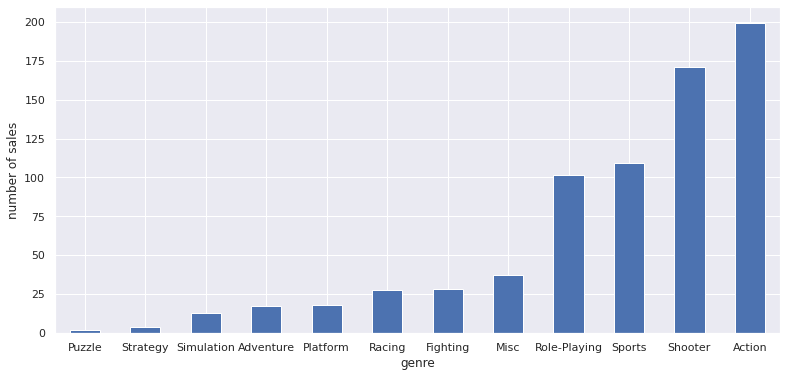

In [37]:
data_actual.groupby('genre')['total_sales'].sum().sort_values().plot(kind='bar', figsize=(13,6), rot=0, grid=True)
plt.ylabel('number of sales')
plt.show()

In [38]:
data_actual.groupby('genre')['total_sales'].agg(['mean', 'median'])

,mean,median
genre,,
Action,0.322068,0.090
Adventure,0.094865,0.030
Fighting,0.470333,0.125
Misc,0.332301,0.090
Platform,0.476053,0.140
Puzzle,0.157857,0.045
Racing,0.398841,0.090
Role-Playing,0.459005,0.110
Shooter,1.335469,0.515


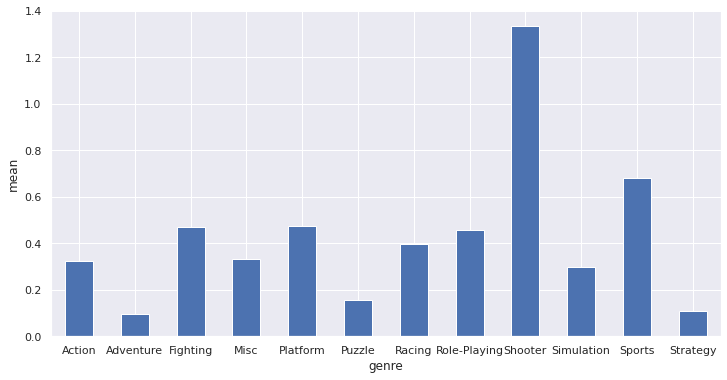

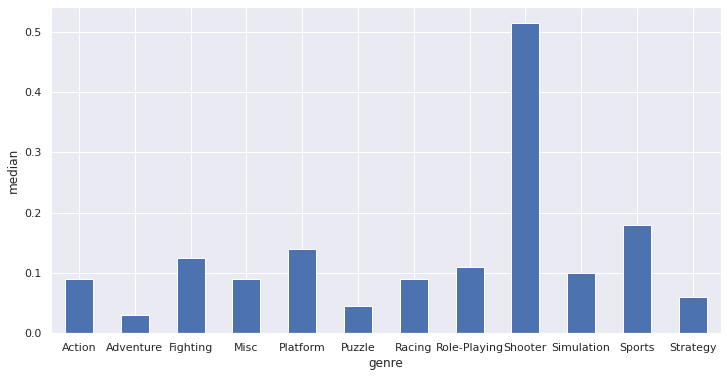

In [39]:
data_actual.groupby('genre')['total_sales'].mean().plot(kind='bar', figsize=(12,6), grid=True, rot=0)
plt.ylabel('mean')
plt.show()
data_actual.groupby('genre')['total_sales'].median().plot(kind='bar', figsize=(12,6), grid=True, rot=0)
plt.ylabel('median')
plt.show()

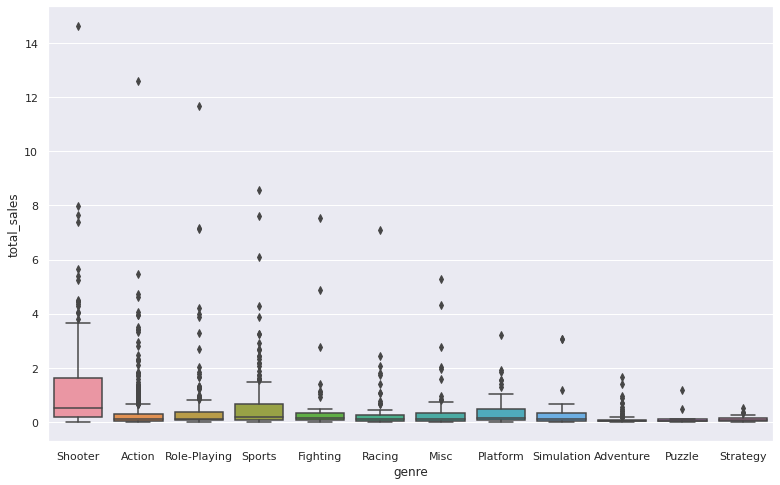

In [40]:
fig, ax = plt.subplots(figsize=(13,8))
sns.boxplot(ax =ax, data=data_actual, x='genre', y='total_sales')
plt.show()

Комментарий: Самым прибыльным жанром является **Shooter**, с самыми низкой прибыльностью **Adventure**. **Shooter** выделяется по всем параметрам, в том время как **Action** имеет более высокое количество продаж, но прибыльность на уровне остальных жанров.

## Портрет пользователя каждого региона

### Самые популярные платформы (топ-5)

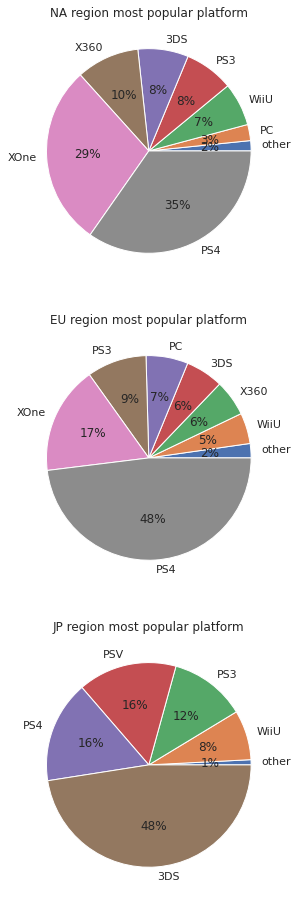

In [41]:
fig_4, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(16,16))
data_actual.replace(['PSV', 'Wii', 'PSP'], 'other')\
.groupby('platform')['na_sales'].sum().sort_values().plot(ax = ax1, kind='pie', grid=True, autopct='%1.0f%%')
ax1.set_title('NA region most popular platform')
ax1.set_ylabel('')
data_actual.replace(['PSV', 'Wii', 'PSP'], 'other')\
.groupby('platform')['eu_sales'].sum().sort_values().plot(ax = ax2, kind='pie', grid=True, autopct='%1.0f%%')
ax2.set_title('EU region most popular platform')
ax2.set_ylabel('')
data_actual.replace(['PC', 'Wii', 'X360', 'XOne', 'PSP'], 'other')\
.groupby('platform')['jp_sales'].sum().sort_values().plot(ax = ax3, kind='pie', grid=True, autopct='%1.0f%%')
ax3.set_title('JP region most popular platform')
ax3.set_ylabel('')
plt.show()

Комментарий: В регионе **NA** побеждает **PS4**, однако **XOne** не отстает, в регионе **EU** с большим отрывом лидирует **PS4**, а вот регион **JP** удивляет, там лидирует **3DS**.

### Самые популярные жанры (топ-5)

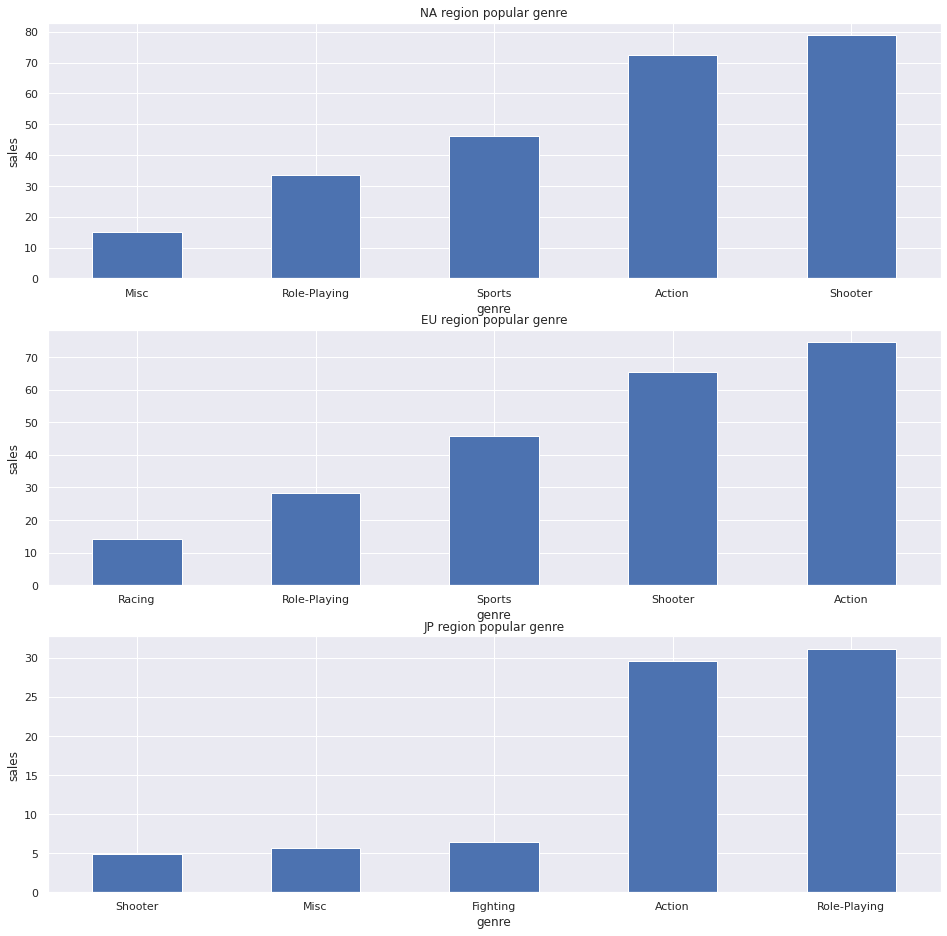

In [42]:
fig_5, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(16,16))
data_actual.groupby('genre')['na_sales'].sum().sort_values()[-5:].plot(ax=ax1, kind='bar', rot=0, grid=True)
ax1.set_title('NA region popular genre')
ax1.set_ylabel('sales')
data_actual.groupby('genre')['eu_sales'].sum().sort_values()[-5:].plot(ax=ax2, kind='bar', rot=0, grid=True)
ax2.set_title('EU region popular genre')
ax2.set_ylabel('sales')
data_actual.groupby('genre')['jp_sales'].sum().sort_values()[-5:].plot(ax=ax3, kind='bar', rot=0, grid=True)
ax3.set_title('JP region popular genre')
ax3.set_ylabel('sales')
plt.show()

In [43]:
print('Самые популярные жанры для NA:', data_actual.groupby('genre')['na_sales'].sum().sort_values(ascending=False)[:5].index.to_list())
print('----------------------------------------------------------------------------------------------------------------')
print('Самые популярные жанры для EU:', data_actual.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)[:5].index.to_list())
print('----------------------------------------------------------------------------------------------------------------')
print('Самые популярные жанры для JP:', data_actual.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)[:5].index.to_list())

Самые популярные жанры для NA: ['Shooter', 'Action', 'Sports', 'Role-Playing', 'Misc']
----------------------------------------------------------------------------------------------------------------
Самые популярные жанры для EU: ['Action', 'Shooter', 'Sports', 'Role-Playing', 'Racing']
----------------------------------------------------------------------------------------------------------------
Самые популярные жанры для JP: ['Role-Playing', 'Action', 'Fighting', 'Misc', 'Shooter']


Комментарий: Топ-5 популярных жанров в регионах **NA** и **EU** практически идентичны, а вот **JP** сильно отличается распределением, где очень сильно доминирует 2 жанра, причем один из которых **Role-Playing**, но если сравнивать по цифрам, то он продается примерно одинаково во всех регионах. Вопросов скорее всего культурных предпочтений, а также того, что население **JP** региона гораздо меньше других рассматриваемых.

### Рейтинг ESRB на продажи в отдельном регионе

In [44]:
data_actual[['na_sales', 'eu_sales', 'jp_sales']].sum()

na_sales    284.06
eu_sales    270.68
jp_sales     93.09
dtype: float64

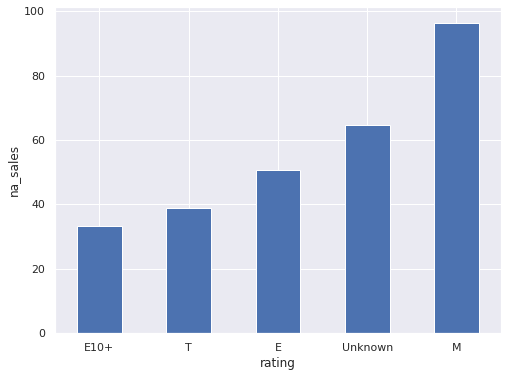

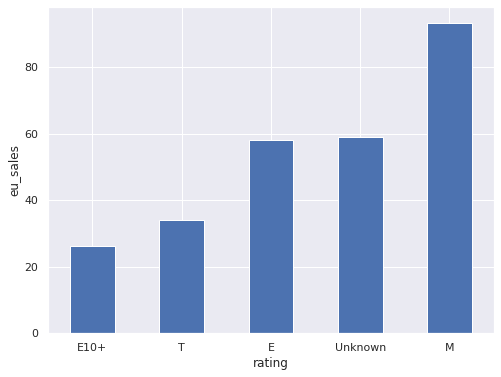

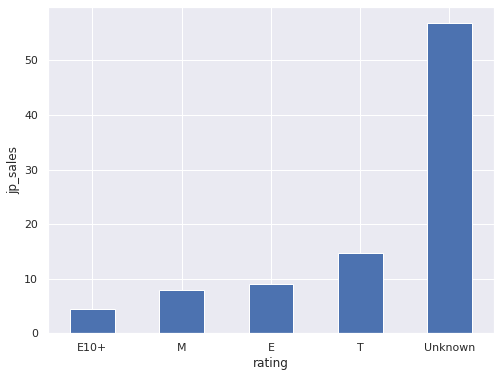

In [45]:
for sales in ['na_sales', 'eu_sales', 'jp_sales']:
    data_actual.groupby('rating')[sales].sum().sort_values().plot(kind='bar', rot=0, grid=True, figsize=(8,6))
    plt.ylabel(sales)
    plt.show()

Комментарий: В регионе **NA** и **EU** популярный рейтинг **M**, на втором месте **Unknown**, в регионе **JP** подавляющее большинство приходится на **Unknown**. Возможно это связано с регулировкой возрастный ограничений в этом регионе, она может не такая жесткая как в **NA** и **EU**, хотя там тоже довольно много **Unknown**.

## Гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Комментарий: Параметр оценки **alpha** зададим 0.5, и будем им пользоваться при всех гипотезах.

$H_{0}$ - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

$H_{1}$ - Средние пользовательские рейтинги платформ Xbox One и PC разные

In [46]:
alpha = 0.05

In [47]:
result_1 = st.ttest_ind(data_actual[data_actual['platform'] == 'XOne']['user_score'].dropna(),
                        data_actual[data_actual['platform'] == 'PC']['user_score'].dropna())
error = abs(1 - data_actual[data_actual['platform'] == 'PC']['user_score']
         .dropna().mean()/data_actual[data_actual['platform'] == 'XOne']['user_score'].dropna().mean())
if (result_1.pvalue/2 < alpha and error > alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


Комментарий: У нас две независимые выборки, кроме того, при проверке дополнительно на равенство средних была введена погрешность **error**, у нас величины дробные, поэтому равенство их возможно только с некоторой точность, была выбрана точность **alpha**, погрешность в 5% оптимально. 

### Средние пользовательские рейтинги жанров Action и Sports разные.

Комментарий:

$H_{0}$ - Средние пользовательские рейтинги жанров Action и Sports одинаковые

$H_{1}$ - Средние пользовательские рейтинги жанров Action и Sports разные

In [51]:
result_2 = st.ttest_ind(data_actual[data_actual['genre'] == 'Action']['user_score'].dropna(),
                        data_actual[data_actual['genre'] == 'Sports']['user_score'].dropna())
error = abs(1 - data_actual[data_actual['genre'] == 'Action']['user_score']
         .dropna().mean()/data_actual[data_actual['genre'] == 'Sports']['user_score'].dropna().mean())
if (result_2.pvalue/2 < alpha and error > alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


Комментарий: Таким образом отвергнуть ни одну из гипотез не получилось. Критерий применялся **ttest_ind** потому что нет никаких предпосылок считать, что эти оценки зависят друг от друга. Кроме того, alpha была выбрана самой стандартной и также на основе ее проверялась процентная разность между средними для более точной оценки.

## Вывод

В ходе проведения анализа сначала была выявлена длительность за которое исчезают платформу, относительно этого значения выбирался актуальный период. После работа проводилась только с актуальными данными, были выявлены потенциально прибыльные платформы: **PS4** и **XOne**, график строчка 26. Была произведена оценка с помощью **boxplot**, где выбросы вполне имеют место быть, поскольку вполне возможны игры так сильно "выстрелившие" на рынке. Были рассмотрены влияние оценок пользователей и критиков, где корреляция очень сильно зависит от платформы, так например продажи игр на платформе **PSV** не зависят ни от чьих оценок, в том время как продажи игр на платформе **WiiU** сильнее всех зависят от оценок пользователей, что видно на соответствующих  графиках. Самым прибыльным жанром игр оказался **Shooter**, об этом можно сказаться на основе анализа средних, медианных значений и графика **boxplot**. Был составлен портрет пользователей регионо **NA**, **EU** и **JP**, где рынок Японии весьма отличается от рынка двух других регионов. Были проверены гипотеза равенства средних значений пользовательского рейтинга для платформ **Xbox One** и **PC**, а также неравенства для жанров **Action** и **Sports**. Отвергнуть обе не удалось.